In [17]:
import glob
import os, sys, shutil
import random
from tqdm import tqdm

import numpy as np
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.applications import xception, resnet50, imagenet_utils, inception_v3, inception_resnet_v2
import cv2
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications

import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt

from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

# 数据集下载

使用 [Dogs vs. Cats Redux: Kernels Edition](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition)提供的数据集合。

获取步骤如下:

1. 注册``kaggle``。
2. 进入 [Dogs vs. Cats Redux: Kernels Edition/rules](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/rules)，接受规则。
3. ``pip install kaggle`` 安装``kaggle api``工具。
4. 使用``kaggle competitions download -c dogs-vs-cats-redux-kernels-edition``下载数据。

``kaggle api``的详细使用，可以参照[官方文档](https://github.com/Kaggle/kaggle-api)。

# 数据集处理

我们在这里对数据集进行处理后，最后生成指定的目录，给后面项目使用。

## 0. 数据集统计

In [1]:
train_input_dir = 'input/train'
test_input_dir = 'input/test'

# Make sure you include https://www.kaggle.com/keras/vgg16/data as your data source
#vgg_model_path = '../input/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

epochs = 20
batch_size = 20
img_width, img_height = 150, 150

training_n_bound = None  # set to None to use the entire training dataset; it took about 2 hours at my Macbook Pro.

In [11]:
def my_display(imgs, n=5, fdir='input/train/'):    
    fig = plt.figure(figsize=(16, 8))
    for j, fn in enumerate(imgs):
        fn2 = fdir+fn
        img = load_img(fn2, target_size=(150, 150))
        fig.add_subplot(1, n, j + 1)
        f = plt.imshow(img)
        plt.title('{}'.format(fn))
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
    plt.show()

In [328]:
def gen_image_label(directory):
    ''' A generator that yields (label, id, jpg_filename) tuple.'''
    for root, dirs, files in os.walk(directory):
        for f in files:
            _, ext = os.path.splitext(f)
            if ext != '.jpg':
                continue
            basename = os.path.basename(f)
            splits = basename.split('.')
            if len(splits) == 3:
                label, id_, ext = splits
            else:
                label = None
                id_, ext = splits
            fullname = os.path.join(root, f)
            img = load_img(fullname)
            yield label, int(id_), fullname, img.size

In [357]:
lst = list(gen_image_label(train_data_dir))

In [363]:
random.shuffle(lst)
lst2 = lst[:10]    
train_df = pd.DataFrame(lst, columns=['label', 'id', 'filename', 'size'])
train_df = train_df.sort_values(by=['label', 'id'])
train_df.head(5)

,label,id,filename,size
20458,cat,0,input/train/cat.0.jpg,"(500, 374)"
11242,cat,1,input/train/cat.1.jpg,"(300, 280)"
21430,cat,2,input/train/cat.2.jpg,"(312, 396)"
5170,cat,3,input/train/cat.3.jpg,"(500, 414)"
8647,cat,4,input/train/cat.4.jpg,"(499, 375)"


/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


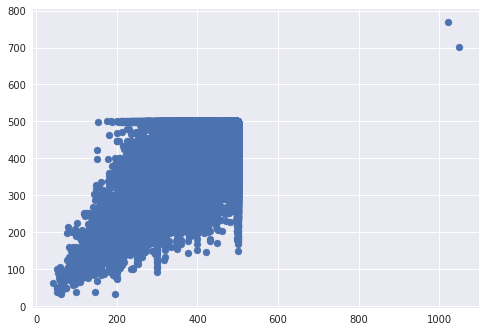

In [364]:
size_df = pd.DataFrame(list(train_df['size'].values), columns=['w', 'h'])
plt.scatter(size_df['w'], size_df['h'])
plt.show()

/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


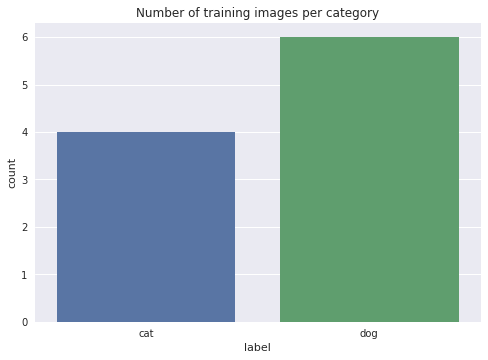

In [332]:
sns.countplot(train_df.label)
plt.title('Number of training images per category')
plt.show()

## 2. 目录整理

项目使用keras的ImageDataGenerator.flow_from_directory，对图片数据进行加载和流化，所以目录要整理成ImageDataGenerator.flow_from_directory可以识别的格式，flow_from_directory要求按类别进行存放。如对猫狗问题：

```
- train
  -- dog
      --- dog.01.jpg
  -- cat
      --- cat.01.jpg
```
这样处理后，才能使用flow_from_directory对``train``目录进行图片流化

In [6]:
train_all_dir = 'data/train_all'
train_dir = 'data/train'
valid_dir = 'data/valid'
test_dir = 'data/test'

# 删除并重建目录
def rebuild_dir(dirname):
    if os.path.exists(dirname):
        shutil.rmtree(dirname)
    os.mkdir(dirname)

In [18]:
rebuild_dir('data')
rebuild_dir('data/test')
os.symlink('../../input/test', 'data/test/test') 

In [3]:
def rebuild_dir_by_datasets(imgs, fdir):
    rebuild_dir(fdir)
    rebuild_dir(fdir+'/dog')
    rebuild_dir(fdir+'/cat')
    
    for name in imgs:
        if 'dog' in name:
            os.symlink('../../../input/train/'+name, fdir+'/dog/'+name)
        else:
            os.symlink('../../../input/train/'+name, fdir+'/cat/'+name)       

In [9]:
# 猫狗各取一半，0~1,2500
TRAIN_SIZE = 2500

TRAIN_ALL_DATA = ['cat.%d.jpg' % i for i in range(TRAIN_SIZE)] + ['dog.%d.jpg' % i for i in range(TRAIN_SIZE)]
rebuild_dir_by_datasets(TRAIN_ALL_DATA, train_all_dir)

确认符号文件是否正常

/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


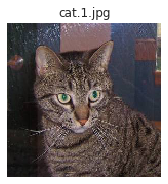

In [168]:
my_display(['cat.1.jpg'], fdir=train_all_dir+'/cat/')

/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


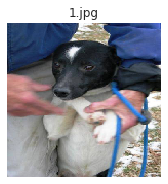

In [315]:
my_display(['1.jpg'], fdir=test_dir+'/test/')

随机化分割训练数据成验证数据集和验证数据集

In [14]:
from sklearn.model_selection import train_test_split

# 设置随机种子
np.random.seed(2018)
# 生成训练集和验证集，猫狗等概率。

def split_train_data():
    global TRAIN_ALL_DATA
    
    DOG_DATA = [i for i in TRAIN_ALL_DATA if 'dog' in i]
    CAT_DATA = [i for i in TRAIN_ALL_DATA if 'cat' in i]

    # 对齐数据，让猫狗数据量一样大
    COUNT = min(len(DOG_DATA), len(CAT_DATA))
    DOG_DATA = DOG_DATA[:COUNT]
    CAT_DATA = CAT_DATA[:COUNT]
    
    len1 = len(TRAIN_ALL_DATA)
    TRAIN_ALL_DATA = DOG_DATA+CAT_DATA
    print("len: {}->{}".format(len1, len(TRAIN_ALL_DATA)))
    
    TRAIN_DOG_DATA, VALID_DOG_DATA, TRAIN_CAT_DATA, VALID_CAT_DATA = train_test_split(DOG_DATA, CAT_DATA, test_size=0.2, shuffle=True)
    TRAIN_DATA = TRAIN_DOG_DATA+TRAIN_CAT_DATA
    VALID_DATA = VALID_DOG_DATA+VALID_CAT_DATA
    
    rebuild_dir_by_datasets(TRAIN_DATA, fdir=train_dir)
    rebuild_dir_by_datasets(VALID_DATA, fdir=valid_dir)
    

In [117]:
split_train_data()

/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


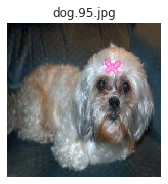

In [120]:
fn = TRAIN_DATA[0]
my_display([fn], fdir=train_dir+'/'+ "dog/" if 'dog' in fn else "cat/")

## 3. 异常数据处理

我们观察可以看到很多数据是有异常的。比如下面图片数据，明显不是猫的图片:

/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


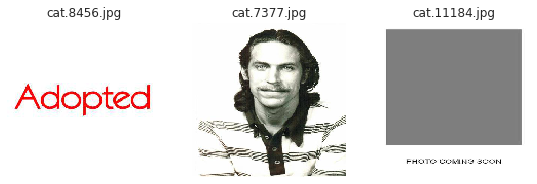

In [12]:
imgs = ['cat.8456.jpg', 'cat.7377.jpg', 'cat.11184.jpg']
my_display(imgs)

一个思路是使用预训练的模型进行标记，``ImageNet``上1000多分类中，猫狗的类别，依次是:

In [27]:
dog_categores = [
 'n02085620','n02085782','n02085936','n02086079'
,'n02086240','n02086646','n02086910','n02087046'
,'n02087394','n02088094','n02088238','n02088364'
,'n02088466','n02088632','n02089078','n02089867'
,'n02089973','n02090379','n02090622','n02090721'
,'n02091032','n02091134','n02091244','n02091467'
,'n02091635','n02091831','n02092002','n02092339'
,'n02093256','n02093428','n02093647','n02093754'
,'n02093859','n02093991','n02094114','n02094258'
,'n02094433','n02095314','n02095570','n02095889'
,'n02096051','n02096177','n02096294','n02096437'
,'n02096585','n02097047','n02097130','n02097209'
,'n02097298','n02097474','n02097658','n02098105'
,'n02098286','n02098413','n02099267','n02099429'
,'n02099601','n02099712','n02099849','n02100236'
,'n02100583','n02100735','n02100877','n02101006'
,'n02101388','n02101556','n02102040','n02102177'
,'n02102318','n02102480','n02102973','n02104029'
,'n02104365','n02105056','n02105162','n02105251'
,'n02105412','n02105505','n02105641','n02105855'
,'n02106030','n02106166','n02106382','n02106550'
,'n02106662','n02107142','n02107312','n02107574'
,'n02107683','n02107908','n02108000','n02108089'
,'n02108422','n02108551','n02108915','n02109047'
,'n02109525','n02109961','n02110063','n02110185'
,'n02110341','n02110627','n02110806','n02110958'
,'n02111129','n02111277','n02111500','n02111889'
,'n02112018','n02112137','n02112350','n02112706'
,'n02113023','n02113186','n02113624','n02113712'
,'n02113799','n02113978']

cat_categores=[
'n02123045','n02123159','n02123394','n02123597'
,'n02124075','n02125311','n02127052']

In [8]:
def dog_or_cat(pred):
    for category in pred:
        if category[0] in dog_categores:
            return 'dog'
        if category[0] in cat_categores:
            return 'cat'
    return None

In [9]:
model2 = xception.Xception(weights='imagenet')

In [ ]:
model = resnet50.ResNet50(weights='imagenet')

In [10]:
def fiter_none_cat_or_dog_files_by_model(fn, model, top=20):
    if model.name == 'xception':
        img = load_img(train_input_dir+'/'+fn, target_size=(224, 224))
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = xception.preprocess_input(x)
        preds = model.predict(x)
        decode_preds = xception.decode_predictions(preds, top)[0]
    else: 
        img = load_img(train_input_dir+'/'+fn, target_size=(224, 224))
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = resnet50.preprocess_input(x)
        preds = model.predict(x)
        decode_preds = resnet50.decode_predictions(preds, top)[0]

    res = dog_or_cat(decode_preds)
    if res is None:
        return True
    return None

In [228]:
def my_display(imgs, n=5, fdir='input/train/'):    
    fig = plt.figure(figsize=(16, 8))
    lines = len(imgs)//n+1
    for j, fn in enumerate(imgs):
        fn2 = fdir+fn
        img = load_img(fn2, target_size=(150, 150))
        fig.add_subplot(lines, n, j + 1)
        f = plt.imshow(img)
        plt.title('{}'.format(fn))
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
    plt.show()

In [ ]:
non_files = []
for i in TRAIN_ALL_DATA:
    if fiter_none_cat_or_dog_files_by_model(i, model2, 20):
        non_files.append(i)

In [292]:
len(non_files)

17

/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


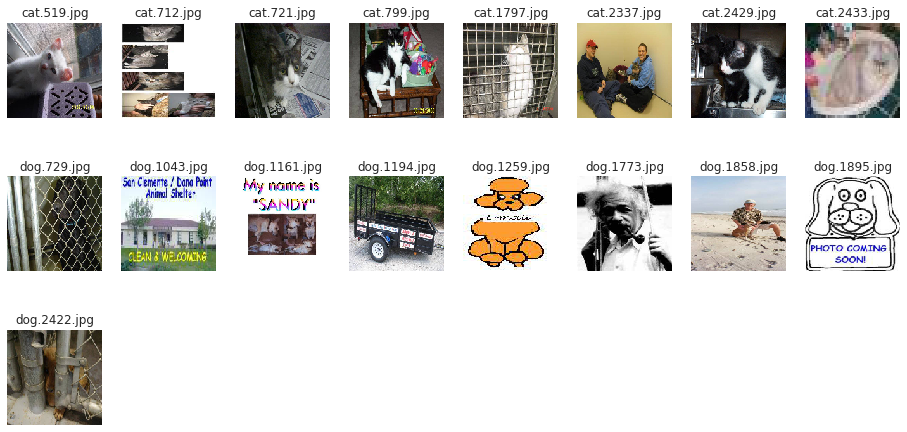

In [294]:
my_display(non_files, n=8)

In [21]:
# 保存记录的异常数据
non_files = ['cat.519.jpg', 'cat.712.jpg', 'cat.721.jpg', 'cat.799.jpg', 'cat.1797.jpg', 'cat.2337.jpg',
            'cat.2429.jpg', 'cat.2433.jpg', 'dog.729.jpg', 'dog.1043.jpg', 'dog.1161.jpg', 'dog.1194.jpg', 'dog.1259.jpg', 'dog.1773.jpg', 'dog.1858.jpg', 'dog.1895.jpg', 'dog.2422.jpg']


In [2]:
len(non_files)

17

In [22]:
# 从TRAIN_ALL_DATA中剃掉这些异常数据
TRAIN_ALL_DATA2 = TRAIN_ALL_DATA
TRAIN_ALL_DATA = [i for i in TRAIN_ALL_DATA if i not in non_files]

In [25]:
# 从train_all目录中删除图片
for i in TRAIN_ALL_DATA2:
    if i not in TRAIN_ALL_DATA:
        if 'dog' in i:
            os.remove(train_all_dir+'/dog/'+i)
        else:
            os.remove(train_all_dir+'/cat/'+i)